#A multidimensional landscape of brains

SOON AFTER MOTIVATION, STATE CLEARLY THE POINT OF THE ARTICLE, INTRODUCE THE PLAN OF ITS ARGUMENT.

Contrary to geographic atlases which describe aspects of the same object, the earth, brain atlases aim to capture features common to many different individual brains. For example, Brodman's atlas is used under the asumption that the neocortex of all humans is organised following a shared pattern of cytoarchitectonic differentiation. But no two brains are identical. Most evidently, there is a large variation in brain volume and it is not unusual to find within a single population a 2-fold difference between the smallest and the largest brain. In their influencial atlas, Talairach and Tourneaux provided a simple method to account for these differences in brain geometry: each brain is to be placed within a proportional grid, adjusted to the dimensions of individual brains. The underlying assumption is that human brains are to some extent scaled up/down versions one of another. This is also implicitly assumed when 'relative' brain volumes are computed by dividing the volume of subregions by that of the total brain (or the total intracranial space, etc.).

The assumption is weakened by non-linear alignment. Here, the size of different regions of the brain can be locally deformed to fit a global template. Once that deformation is computed, and admiting that the result is satisfactory, non-linear alignment algorithms produce a map of the local deformations for each individual. These maps can be used in the later analyses as variables of interest or as covariables.

Surface based maps add an additional hypothesis, in which the topology of the neocortex is taken into account. Within the space of the cortical surface atlas, we

In [1]:
from IPython.display import display, HTML
# Hide/Show input area
display(HTML(
"<script>$('.mytoggle').remove();$('.code_cell').prepend(\"<button style='width:32px' class='mytoggle' onclick=\'f(this)\'>&gt;</button>\");\
function f(e){$(e).parent().find('.input').toggle()}</script>"
))

In [1]:
%matplotlib inline
import numpy as np;
import matplotlib.pyplot as plt;
import scipy
import scipy.cluster.hierarchy as sch
from scipy import linalg
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (4.0, 4.0)

def imshowcluster(D):
    # Based on http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python
    fig = plt.figure()

    # Compute and plot dendrogram.
    axdendro1 = fig.add_axes([0.0,0.2,0.19,0.8])
    Y1 = sch.linkage(D, method='centroid')
    Z1 = sch.dendrogram(Y1, orientation='right')
    axdendro1.set_xticks([])
    axdendro1.set_yticks([])

    # Compute and plot dendrogram.
    axdendro2 = fig.add_axes([0.2,0.00,0.6,0.19])
    Y2 = sch.linkage(D.transpose(), method='centroid')
    Z2 = sch.dendrogram(Y2, orientation='bottom')
    axdendro2.set_xticks([])
    axdendro2.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.2,0.2,0.6,0.8])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    plt.colorbar(im, cax=axcolor)

    # Add axes labels
    axmatrix.set_xticks(range(D.shape[0]))
    axmatrix.set_xticklabels(idx1, minor=False)
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    plt.xticks(rotation=-90, fontsize=4)

    axmatrix.set_yticks(range(D.shape[1]))
    axmatrix.set_yticklabels(idx2, minor=False)
    axmatrix.yaxis.set_label_position('right')
    axmatrix.yaxis.tick_right()
    # Display and save figure.
    #fig.savefig('dendrogram.png')

def multihist(D,m,n):
    fig, axes = plt.subplots(nrows=m, ncols=n);
    for i in range(m):
        for j in range(n):
            axes[i,j].hist(P[:,n*i+j],20);

/Users/roberto/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/nose/plugins/manager.py:418: UserWarning: Module argparse was already imported from /Applications/_Sci/Canopy.app/appdata/canopy-1.1.0.1371.macosx-x86_64/Canopy.app/Contents/lib/python2.7/argparse.pyc, but /Users/roberto/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages is being added to sys.path
  import pkg_resources


In [2]:
N=1000; # number of subjects
Nr=9; # number of brain regions
Ni=3; # number of independent latent effects
rng = np.random.RandomState(123);

### Variation around a single mean model

The measurements of the single model are placed at the origin.

The variation of the measurements in the population is random, additive and with a gaussian distribution. Additive variation only makes sense if it is small, otherwise it could lead to meaningless values (such as negative volumes). It is also possible that the measurements are logarithms, which prevents the problem.

In the example, variation along all axes is the same ($\sigma=1$), but we could imagine a case in which some regions are much more variable than some others. For example, the amount of variation of each region could be drawn from a gaussian distribution:

In both cases, we could argue that a single model -- the mean -- could capture the general structure of the brain in the population. The addition of an estimation of the variability of each structure would allow us to detect outliers more precisely.
Case of two groups, one of controls where the structure is well approximated by the mean model, and another one where either the mean value of some structures or their variability are significantly different.
In the case of gender differences, i.e., the case were it is possible to split the normal population in two different groups, we could consider that both males and females are differ from the mean model.

### Random phenotypes of the same variance

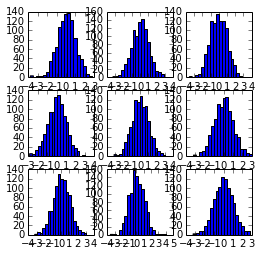

In [3]:
# Random Nr phenotypes, all with the same variance
P=rng.randn(N,Nr);
multihist(P,3,3);


### Random uncorrelated phenotypes of different variance

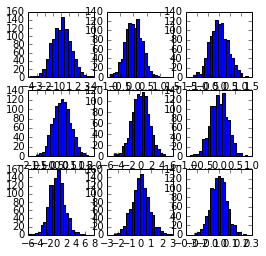

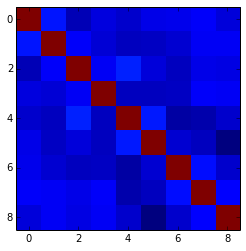

In [4]:
# Nr phenotypes, with Nr different variances
sd=np.abs(rng.randn(1,Nr));
P=sd*rng.randn(N,Nr);
multihist(P,3,3);

# In any case, the variance-covariance matrix is 0 off diagonal
m=np.corrcoef(np.transpose(P));
plt.figure();
plt.imshow(m,interpolation="nearest")

###A landscape of brain models
In the previous examples, the model is a single point in Nr-dimensional space, eventually surrounded by a hyper-ellipsoid of dispersion.
Now we consider the case where instead of a single Nr-dimensional point being the reference for the population, there is a higher-dimensional landscape of models. The difference is that between classification and regression. Previously, we had a single point that defined the class of the human brains, probably two classes, if we were looking at males and females, for example. For each subject in our population we can compute a distance to the class by computing the distance to the single point that represents it. The case of regression appears when measurements show correlation. In that case, it is more meaningful to compute the distance to the regression surface than to the barycentre of the population. That regression surface represents in some sense the multidimensional landscape of possible brain structures.

Case of a single measurement: height (continuous), males/females (binary).

Case of 2 measurements: height, brain volume, males/females.

The Nr measurements can be each one correlated with another, in which case a smaller set of Ni independent latent variables may capture a large part of the variance. We could then generate the Nr measurements as linear combinations of the Ni variables.

The phenotype of each of the Nr regions is a random linear combination of the Ni independent latent dimensions:
$P = Pi \cdot M^T$

### Random correlated phenotypes of random variance

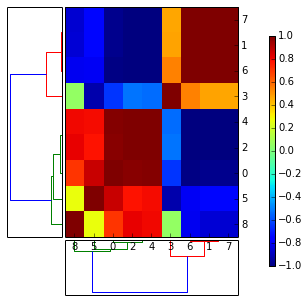

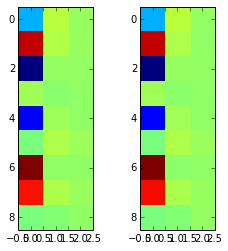

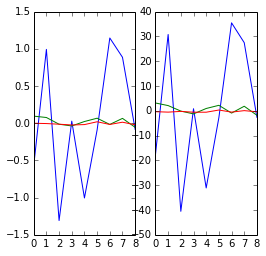

In [6]:
# 1. Create correlated data
# Linear combination of Ni uncorrelated variables that produce the Nr correlated variables.
# (combination vectors are of unitary norm)
M=rng.randn(Nr,Ni);
for i in range(Nr):
    M[i,:]/=linalg.norm(M[i,:]);

# Scale with random eigenvalues
W=-np.sort(-np.abs(rng.randn(Ni)));
M=M.dot(np.diag(W));

# Random Ni values
Pi=rng.randn(N,Ni);

# Random Nr values produced by combining the independent Ni values
# The Nr regions are correlated among them
P=Pi.dot(M.T);
m=np.corrcoef(P.T);
plt.figure();
#plt.imshow(m,interpolation="nearest");
imshowcluster(m);

# 2. Try to guess M from P
U,S,VT=linalg.svd(P,full_matrices=False)
S=np.diag(S);
SVT=S.dot(VT);
M1=SVT[:Ni,:].T;

plt.figure();
plt.subplot(1,2,1);
plt.imshow(M,interpolation="nearest");
plt.subplot(1,2,2);
plt.imshow(M1,interpolation="nearest");

plt.figure();
plt.subplot(1,2,1);
plt.plot(M)
plt.subplot(1,2,2);
plt.plot(M1)

#X_homo = X + sigma * rng.randn(N, Nr); # Adding homoscedastic noise
#sigmas = sigma * rng.rand(Nr) + sigma / 2.0; # Adding heteroscedastic noise
#X_hetero = X + rng.randn(N, Nr) * sigmas

In [7]:
import plotly.plotly as py
from plotly.graph_objs import *

# plotly scatter3d
trace1 = Scatter3d(
        x=Pi[:,0],
        y=Pi[:,1],
        z=Pi[:,2],
        mode="markers",
        marker=dict(
            opacity=0.2
        )
    )
data = Data([trace1])
py.plot(data)

# plotly heatmap
mat=Heatmap(z=U);
data=Data([mat]);
py.plot(data)

u'https://plot.ly/~r03ert0/28'